In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import tensor

import data_processing as dp
import model_evaluation as me

In [154]:
####################
# LOADING THE DATA #
####################
SUBJECTS = ['HH']
SCENES = ['FlatWalkStraight', 'FlatWalkCircular', 'FlatWalkStatic']
TRIALS = ('FW walking')

gait_cycles = dp.read_gait_cycles(SUBJECTS, SCENES, TRIALS)
df = pd.concat(gait_cycles)

Reading FW walking_1.csv
Reading FW walking_2.csv
Reading FW walking_3.csv
Reading FW walking_4_badForcePlate.csv
Reading FW walking_5.csv
Reading FW walking_6_badForcePlate.csv


In [155]:
def filter(df):
    # Ignore readings of force plate 1 (loose)
    df = df[(df['fp1_l'] != 1) & (df['fp1_l'] != 1)]

    # # Only keep masked rows
    df = df[df['valid_mask_feet'] == 1]
    df = df[df['correct_mask_ins'] == 1]

    # Removes rows for which no target label is available
    df = df[(df['Ftot_l'] < 0.05) | (df['Fz_l'] != 0)]
    df = df[(df['Ftot_r'] < 0.05) | (df['Fz_r'] != 0)]

    # Remove rows with non-available values
    df = df.dropna()

    return df

df_filtered = filter(df)

In [156]:
######################
# FEATURE EXTRACTION #
######################
X_test = dp.extract_features(df_filtered)
Y_test = df_filtered[['Fx_l', 'Fy_l', 'Fz_l', 'Tz_l',
                      'Fx_r', 'Fy_r', 'Fz_r', 'Tz_r']]

Y_test = tensor(Y_test.to_numpy().reshape((-1, 8)), dtype=torch.float32 )

In [157]:
DIR = 'results/FW walking/20240523-221618'

In [162]:
import importlib
import models
importlib.reload(models.stm_regressor)
from models.stm_regressor import STMRegressor

full_grf_estimator = STMRegressor(DIR)
Y_pred = full_grf_estimator(X_test)

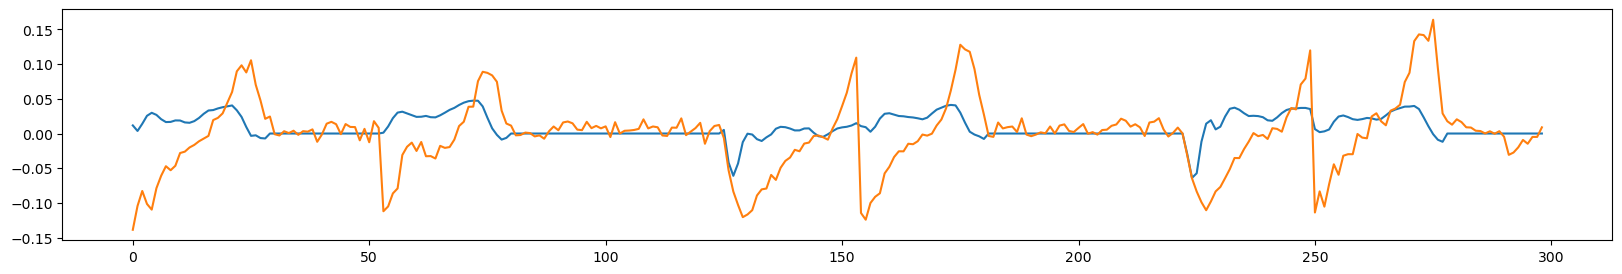

In [164]:
fig = plt.figure(figsize=(20, 3))
gs = fig.add_gridspec(1, 1, hspace=0.22)
axs = gs.subplots(sharex=True)

x = np.arange(df_filtered.index.values.size)
y = df_filtered['Fy_r']
y2 = Y_pred[:, 4].detach().numpy()
axs.plot(x, y)
axs.plot(x, y2)

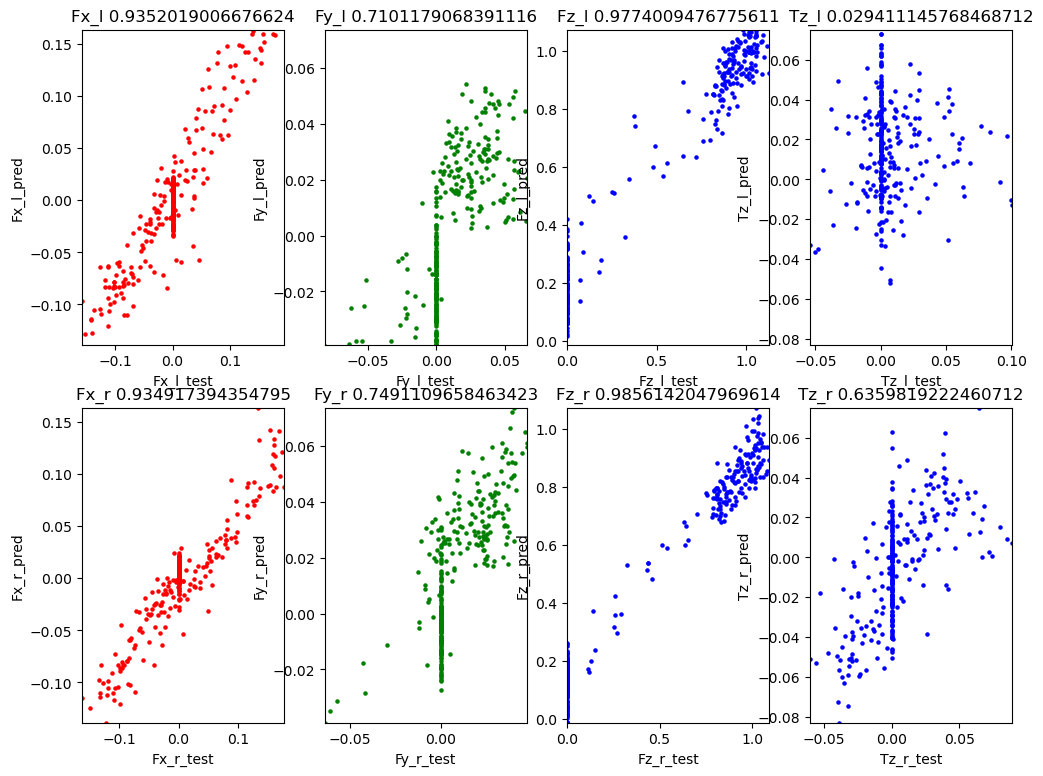

In [166]:
importlib.reload(me)
me.plot_correlations(Y_test, Y_pred)